In [1]:
access_token = ""
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import requests

In [2]:
def getReqDate(d):

    start = pd.to_datetime(d)
    sYear = str(start.year)
    sMonth = ""
    sDay = ""

    if(start.month <10):
        sMonth = "0"+ str(start.month)
    else:
        sMonth = str(start.month)

    if(start.day <10):
        sDay = "0"+ str(start.day)
    else:
        sDay = str(start.day)

    output = sYear+sMonth+sDay+"T000000"
    return output

def getData(start,end,timeFrame,pair):
    access_token = ""
    headers = {'Authorization': 'Bearer ' + access_token}
    fromDate = getReqDate(start)
    toDate = getReqDate(end)
    url = "https://api.cryptoquant.com/v1/"+pair+"/market-data/price-ohlcv?window="+timeFrame+"&from="+fromDate+"&to="+toDate+"&limit=100000"
    temp = pd.DataFrame(requests.get(url, headers=headers).json()['result']['data'])
    temp.sort_values(by = 'date',inplace=True)
    temp.index = pd.to_datetime(temp.date)
    check = pd.to_datetime(temp.index[0])
    check1 = pd.to_datetime(start)
    if check.year != check1.year or check.month != check1.month or check.day != check1.day:
        newEnd = check
        #print(newEnd)
        newDF = pd.concat([getData(start,newEnd,timeFrame,pair), temp])
        dupIndex = newDF.index.duplicated(keep="first")
        newDF = newDF[~dupIndex]
        newDF.sort_index(inplace=True)

        return newDF
    else:
        return temp


In [101]:
#Format: YYYY-MM-DD
start = "2021-01-01"
end = "2022-07-01"
#Format: {"min","hour","day"}
timeFrame = "day"
coin = 'btc'

In [102]:
df = getData(start,end,timeFrame,coin)

In [103]:
def runOVSim(coin, relativeStrike, premium):
    gProfit = 0
    vaultValue = []
    day = []
    lastWeek = 0
    strike = relativeStrike*df.head(1)['close'].tolist()[0]
    cashInVault = coin*premium
    gSpread = 0
    i = 0
    for row in df.iterrows():
        newWeek = i//7
        if newWeek > lastWeek:
            lastWeek = newWeek
            spread = row[1].close - strike
            if spread > 0:
                gProfit +=  coin*spread
                cashInVault -= coin*spread
            strike = relativeStrike*row[1].close
            cashInVault += coin*premium
            gProfit -= coin*premium
        vaultValue.append(cashInVault + coin*row[1].close)
        day.append(i)
        i += 1
    return vaultValue, day, gProfit

In [124]:
vaultValue, day, gProfit = runOVSim(100000, 1.25, 150)

In [132]:
initialVault = vaultValue[0]
vaultPercentIncrease = [(v - initialVault)/initialVault for v in vaultValue]

In [133]:
coinPrice = df.close.tolist()
initcoin = coinPrice[0]
coinPercentIncrease = [(b - initcoin)/initcoin for b in coinPrice]

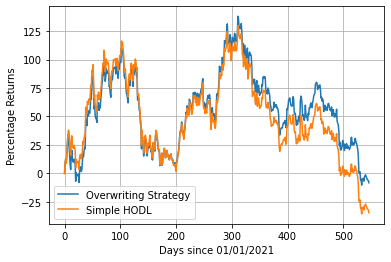

------------ANNUALIZED VOLATILITIES------------
Coin Realized Annual Volatility: 78.07%
Vault Realized Annual Volatility: 75.83%


In [138]:
plt.plot(day, np.multiply(vaultPercentIncrease, 100), label = 'Overwriting Strategy')
plt.plot(day, np.multiply(coinPercentIncrease, 100), label = 'Simple HODL')
plt.xlabel("Days since 01/01/2021")
plt.ylabel("Percentage Returns")
plt.legend()
plt.grid(True)
plt.show()

BTCVol = np.std(np.diff(np.log(btcPrice)))*np.sqrt(365)
VaultVol = np.std(np.diff(np.log(vaultValue)))*np.sqrt(365)
print("------------ANNUALIZED VOLATILITIES------------")
print("Coin Realized Annual Volatility: " + ("{:,.2f}%".format(BTCVol*100)))
print("Vault Realized Annual Volatility: " + ("{:,.2f}%".format(VaultVol*100)))

In [141]:
vaultPercentIncrease[-1]

-0.08215112191509515

In [142]:
coinPercentIncrease[-1]

-0.34503361861218473